## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00


## Setup imports

In [ ]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.2.dev2317
Numpy version: 1.22.4
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5f0418be96b342d978084bb21f8f93d74a06da1c
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.2
gdown version: 4.6.6
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installa

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/BraTS/Task01_BrainTumour')

Mounted at /content/drive


In [ ]:
pip install MedPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.4 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=596212bf4032064f8ae84242d99d6575109c2f29bcd767ad0a6c18bd74eee2fb
  Stored in directory: /root/.cache/pip/wheels/41/46/a2/7c585b78f216a3dd8723dbab5f439822fa5dfbff563757a49e
Successfully built MedPy


In [ ]:
from medpy.metric.binary import hd
import numpy as np
import time
import numpy as np
from medpy.metric.binary import hd
from monai.metrics import compute_hausdorff_distance

## Setup data directory


In [ ]:
directory = os.environ.get("/content/drive/MyDrive/BraTS/Task01_BrainTumour")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpk1wqlxw_


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels


In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


## Load data with DecathlonDataset


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

data_path = '/content/drive/MyDrive/BraTS/Task01_BrainTumour'

# define the dataset and data loaders as before
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=2,
)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=2,
)
batch_size = 1

Task01_BrainTumour.tar: 7.09GB [06:55, 18.3MB/s]                            

2023-04-24 09:02:14,829 - INFO - Downloaded: /tmp/tmpk1wqlxw_/Task01_BrainTumour.tar


2023-04-24 09:02:51,225 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-04-24 09:02:51,229 - INFO - Writing into directory: /tmp/tmpk1wqlxw_.


image shape: torch.Size([4, 240, 240, 155])


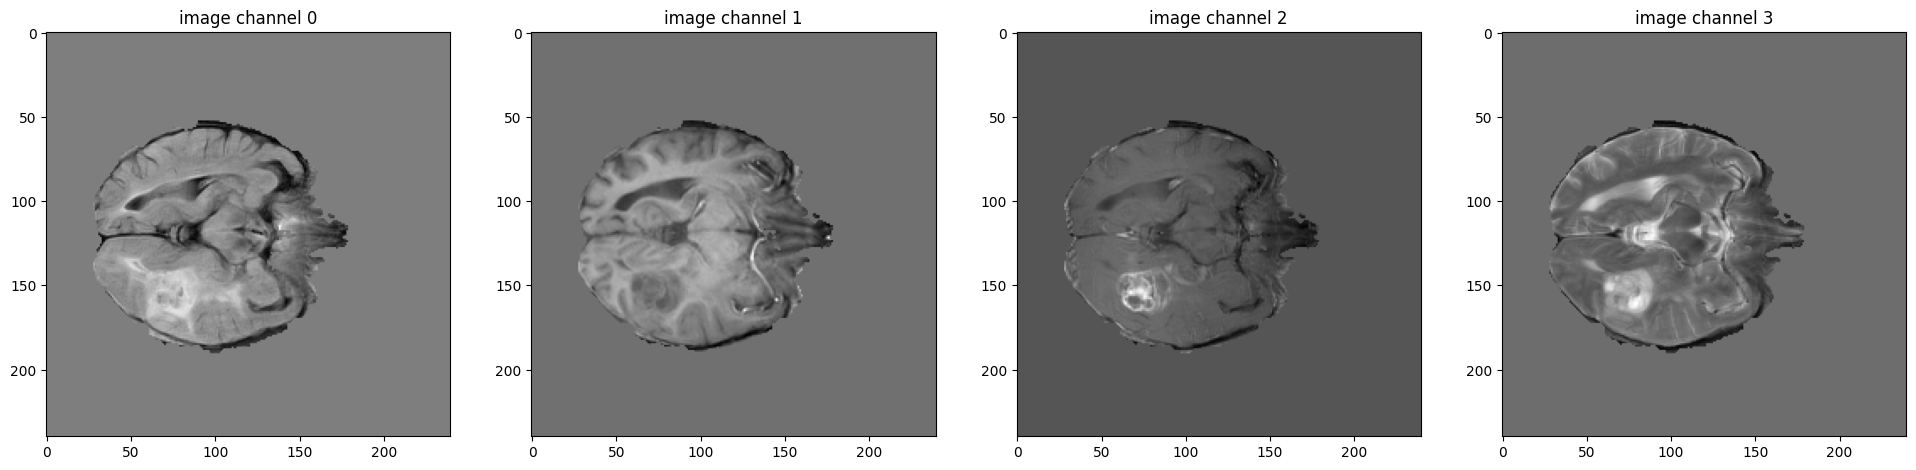

label shape: torch.Size([3, 240, 240, 155])


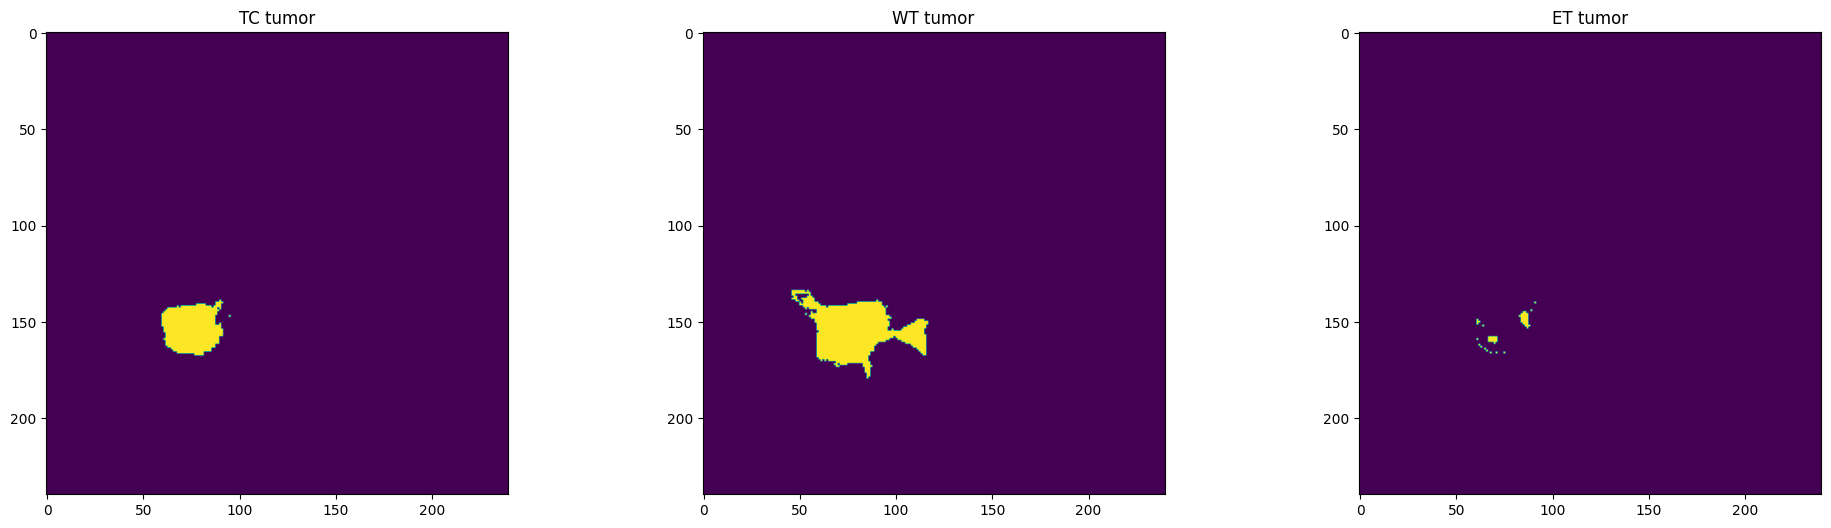

In [ ]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[6]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (24, 6))
# 0: TC 1:WT 2:ET
label_name = ["TC tumor", "WT tumor","ET tumor"]
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(label_name[i])
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

# Training Schedule

In [ ]:
max_epochs = 3
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
      spatial_dims = 3,
      in_channels = 4,
      out_channels=3,
      channels=(16,32,64,238,256),
      strides=(2,2,2,2),
      num_res_units=2,
  ).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
def train(train_loader,val_loader,best_metric):
  epoch_metric = []
  epoch_HD = []

  total_start = time.time()

  for epoch in range(max_epochs):
      batch_HD = []

      epoch_start = time.time()
      print("-" * 10)
      print(f"epoch {epoch + 1}/{max_epochs}")
      model.train()
      epoch_loss = 0
      step = 0

      for batch_data in train_loader:

          step_start = time.time()
          step += 1
          inputs, labels = (
              batch_data["image"].to(device),
              batch_data["label"].to(device),
          )

          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
              outputs = model(inputs)
              loss = loss_function(outputs, labels)

          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          epoch_loss += loss.item()

          print(
              f"{step}/{len(train_ds) // train_loader.batch_size}"
              f", train_loss: {loss.item():.4f}"
              f", step time: {(time.time() - step_start):.4f}"
          )
      lr_scheduler.step()
      epoch_loss /= step
      epoch_loss_values.append(epoch_loss)
      print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

      if (epoch + 1) % val_interval == 0:
          model.eval()
          with torch.no_grad():
              for val_data in val_loader:
                  val_inputs, val_labels = (
                      val_data["image"].to(device),
                      val_data["label"].to(device),
                  )
                  val_outputs = inference(val_inputs)
                  val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                  dice_metric(y_pred=val_outputs, y=val_labels)
                  dice_metric_batch(y_pred=val_outputs, y=val_labels)

                  # Save the HD
                  hausdorff_distance = hd(val_outputs[0], val_labels[0])
                  batch_HD.append(hausdorff_distance)
                  print("BATCH HD", batch_HD)


              metric = dice_metric.aggregate().item()
              metric_values.append(metric)
              metric_batch = dice_metric_batch.aggregate()
              metric_tc = metric_batch[0].item()
              metric_values_tc.append(metric_tc)
              metric_wt = metric_batch[1].item()
              metric_values_wt.append(metric_wt)
              metric_et = metric_batch[2].item()
              metric_values_et.append(metric_et)
              dice_metric.reset()
              dice_metric_batch.reset()

              if metric > best_metric:
                  best_metric = metric
                  best_metric_epoch = epoch + 1
                  best_metrics_epochs_and_time[0].append(best_metric)
                  best_metrics_epochs_and_time[1].append(best_metric_epoch)
                  best_metrics_epochs_and_time[2].append(time.time() - total_start)
                  torch.save(
                      model.state_dict(),
                      os.path.join('/content/drive/MyDrive/BraTS/Task01_BrainTumour', "best_metric_model_2.pth"),
                  )
                  print("saved new best metric model")
              print(
                  f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                  f"\nbest mean dice: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}"
              )
      # Save the metric & HD
      #epoch_metric.append(metric)
      epoch_HD.append(np.mean(batch_HD))
      print("EPOCH METRIC", metric)
      print("EPOCH HD", epoch_HD)

      print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start

  #FoLD
  fold_metric.append(np.mean(epoch_metric))
  fold_HD.append(np.mean(epoch_HD))
  print("FOLD METRIC", fold_metric)
  print("FOLD HD", fold_HD)


# Make the folds for cross validation and train the model

In [ ]:

# perform 5-fold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
fold_metric = []
fold_HD = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
    print(f"Fold {fold_idx + 1}")
    fold_train_ds = Subset(train_ds, train_idx)
    fold_val_ds = Subset(train_ds, val_idx)

    fold_train_loader = DataLoader(fold_train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    fold_val_loader = DataLoader(fold_val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    train_loader = fold_train_loader
    val_loader = fold_val_loader

    train(fold_train_loader,fold_val_loader,best_metric)


Fold 1
----------
epoch 1/3
1/388, train_loss: 0.9820, step time: 7.8742
2/388, train_loss: 0.9587, step time: 0.3619
3/388, train_loss: 0.9776, step time: 0.3762
4/388, train_loss: 0.9882, step time: 0.3546
5/388, train_loss: 0.9373, step time: 0.4039
6/388, train_loss: 0.9955, step time: 0.2326
7/388, train_loss: 0.9938, step time: 0.3927
8/388, train_loss: 0.9862, step time: 0.3295
9/388, train_loss: 0.9656, step time: 0.3900
10/388, train_loss: 0.9624, step time: 0.3090
11/388, train_loss: 0.9779, step time: 0.4383
12/388, train_loss: 0.9599, step time: 0.3339
13/388, train_loss: 0.9964, step time: 0.3875
14/388, train_loss: 0.9842, step time: 0.3129
15/388, train_loss: 0.9606, step time: 0.4073
16/388, train_loss: 0.9817, step time: 0.3276
17/388, train_loss: 0.9670, step time: 0.4458
18/388, train_loss: 0.9592, step time: 0.3507
19/388, train_loss: 0.9575, step time: 0.3658
20/388, train_loss: 0.9849, step time: 0.3278
21/388, train_loss: 0.9755, step time: 0.4221
22/388, train_l

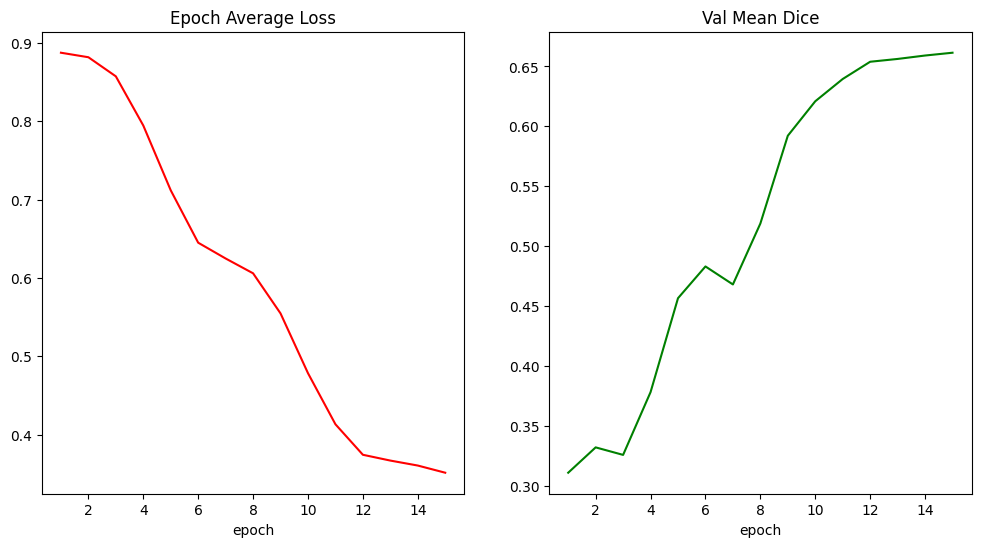

In [ ]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.show()

## Plot the loss and metric

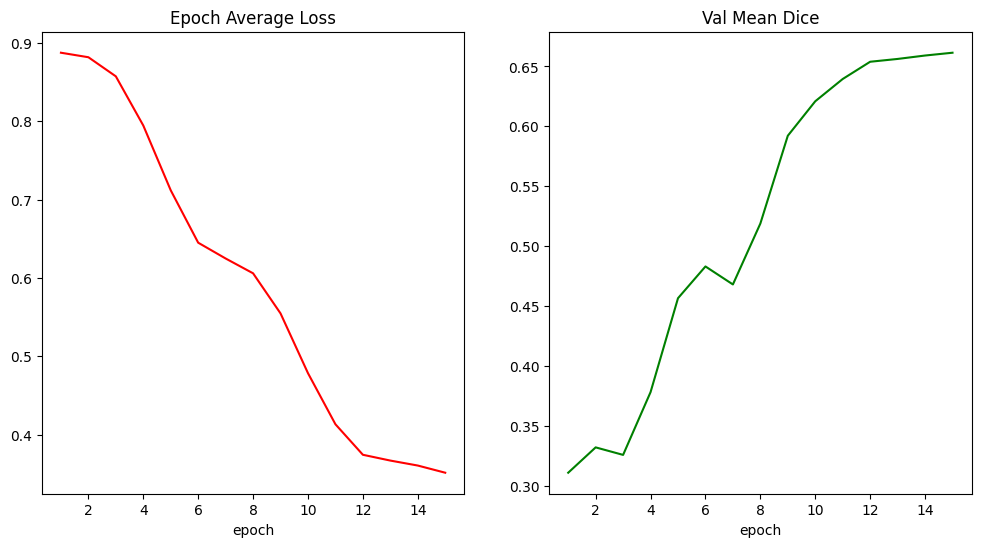

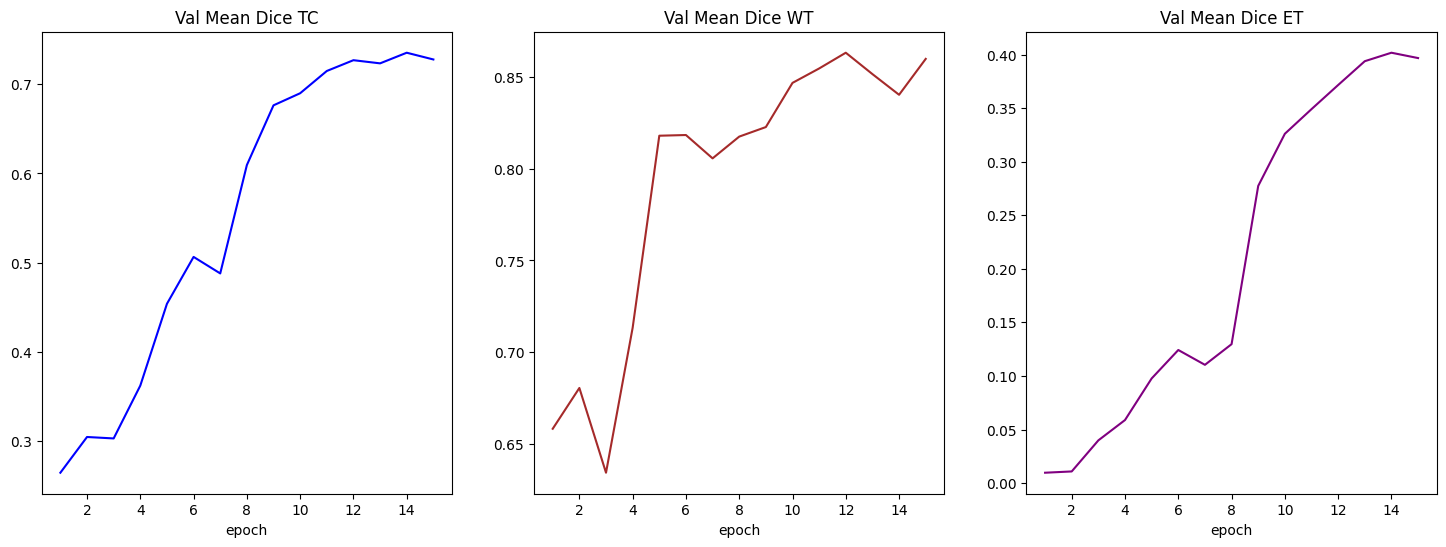

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

# Check best model output with the input image and label

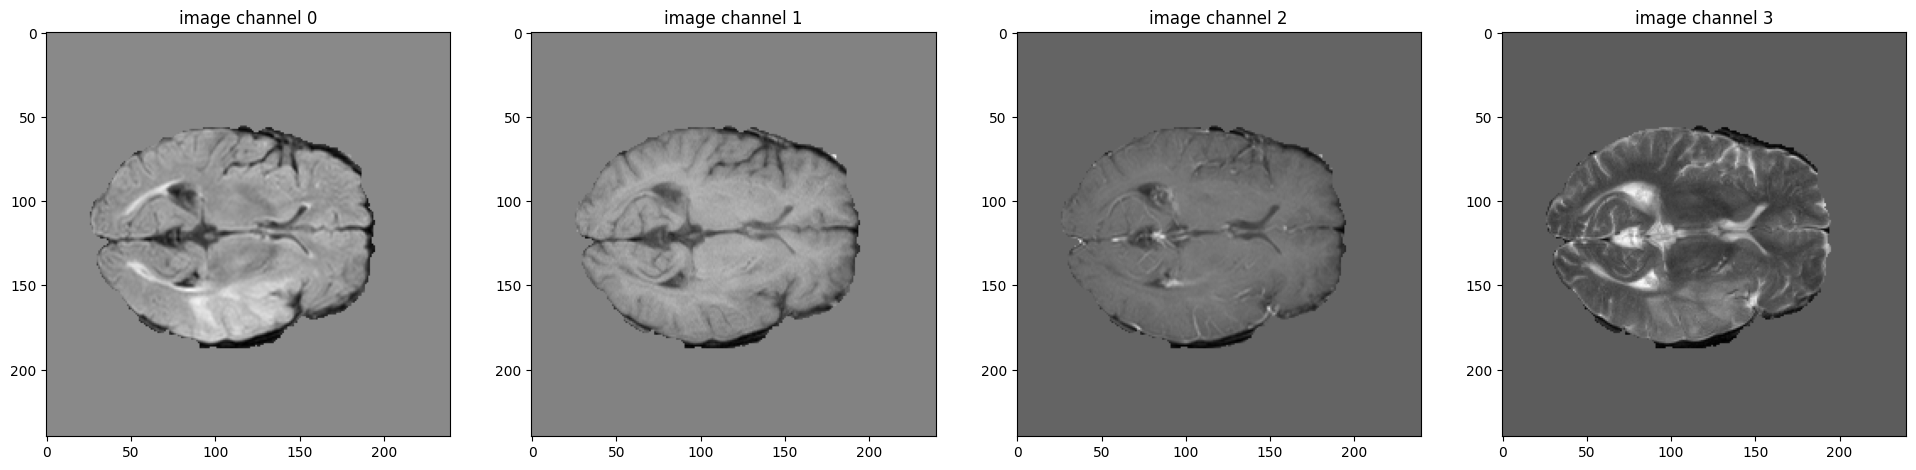

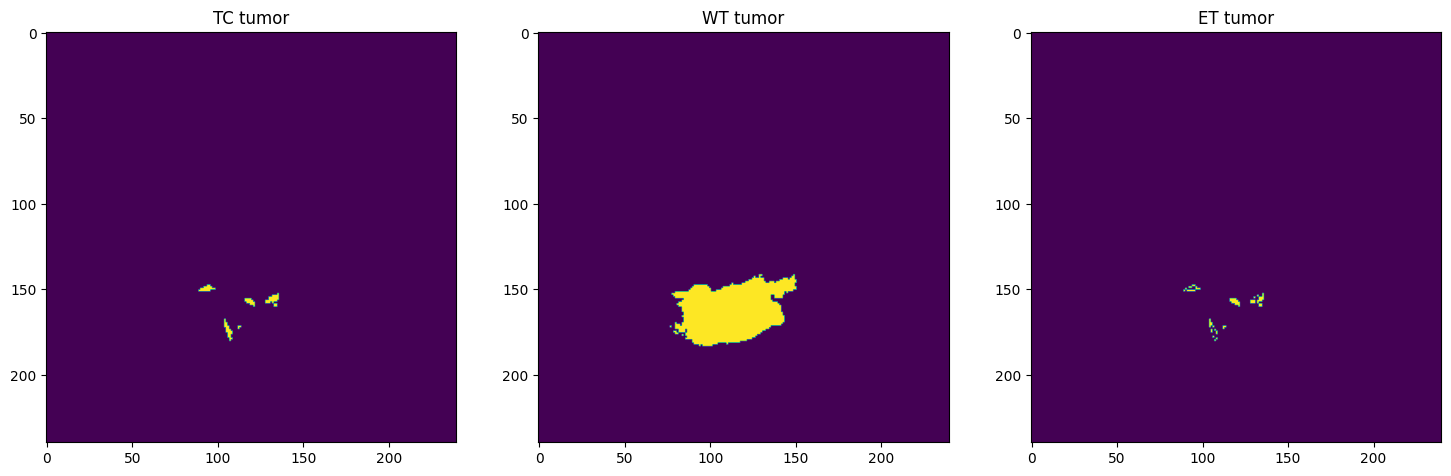

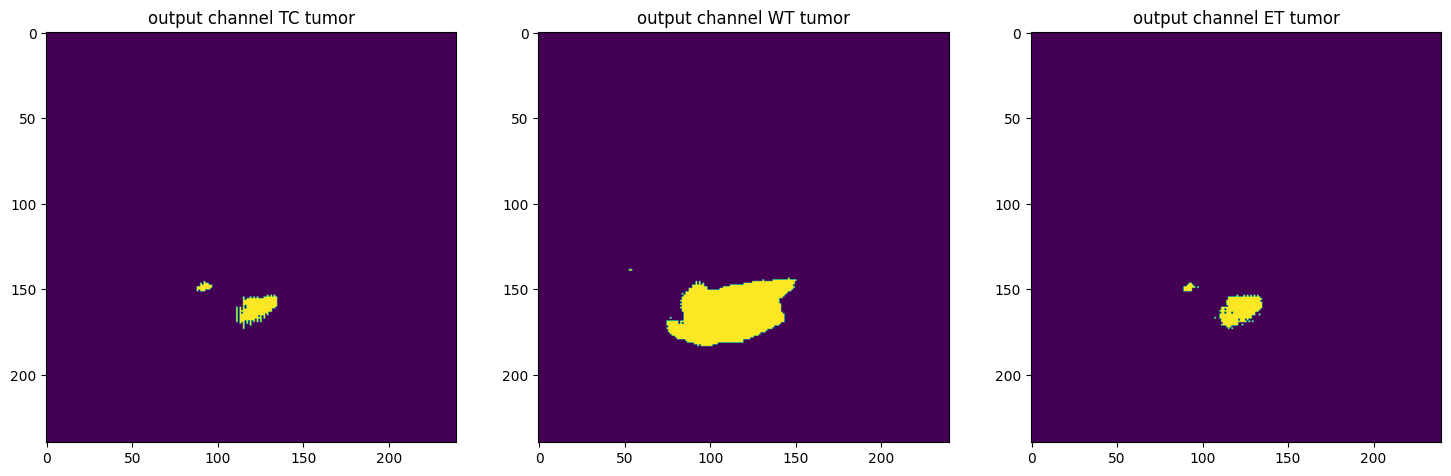

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BraTS/Task01_BrainTumour/best_metric_model_2.pth'))
model.eval()
label_name = ["TC tumor", "WT tumor","ET tumor"]

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[2]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])

    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[2]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(label_name[i])
        plt.imshow(val_ds[2]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {label_name[i]}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

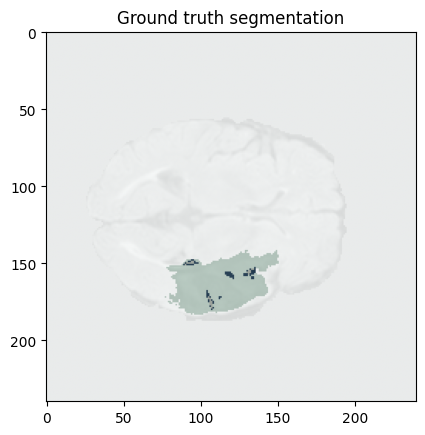

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BraTS/Task01_BrainTumour/best_metric_model_2.pth'))
model.eval()
def get_color_map(segmentation, color):
    cmap = plt.get_cmap(color)
    colored_segmentation = cmap(segmentation)
    return colored_segmentation

with torch.no_grad():
    val_input = val_ds[2]["image"].unsqueeze(0).to(device)
    plt.imshow(val_ds[2]["image"][0, :, :, 70].detach().cpu(), cmap="gray")
    seg_out = val_ds[2]["label"]
    seg_colors = ['Reds', 'Greens', 'Blues']
    for i in range(seg_out.shape[0]):
        plt.title(f"Ground truth segmentation")
        seg_output =  seg_out[i, :, :, 70].detach().cpu()

        plt.imshow(get_color_map(seg_output, seg_colors[i]), cmap="gray", alpha=0.5)

    plt.show()

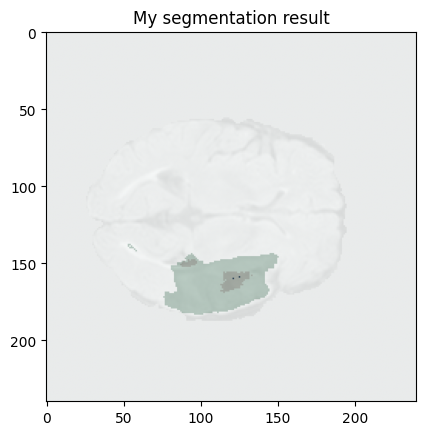

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BraTS/Task01_BrainTumour/best_metric_model_3.pth'))
model.eval()

def get_color_map(segmentation, color):
    cmap = plt.get_cmap(color)
    colored_segmentation = cmap(segmentation)
    return colored_segmentation

with torch.no_grad():
    val_input = val_ds[2]["image"].unsqueeze(0).to(device)
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.imshow(val_ds[2]["image"][0, :, :, 70].detach().cpu(), cmap="gray")

    seg_colors = ['Reds', 'Greens', 'Blues']
    for i in range(val_output.shape[0]):
        plt.title(f"My segmentation result")
        seg_output = val_output[i, :, :, 70].detach().cpu()
        plt.imshow(get_color_map(seg_output, seg_colors[i]), cmap="gray", alpha=0.5)

    plt.show()


## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/BraTS/Task01_BrainTumour/best_metric_model_2.pth'))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.7139434218406677
metric_tc: 0.7663
metric_wt: 0.8861
metric_et: 0.4895


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)